# Goal
This post aims to explain the concept of style transfer step-by-step. Part 3 is about **building a modeling for style transfer from VGG19**. 

![image](https://user-images.githubusercontent.com/8764683/59557772-7d2c0900-901d-11e9-8160-0d0d7f357c79.png)

**Reference**
* [Ste-by-step Data Science - Style Transfer using Pytorch (Part 1)](https://h1ros.github.io/posts/style-transfer-using-pytorch-part-1/)
* [Ste-by-step Data Science - Style Transfer using Pytorch (Part 2)](https://h1ros.github.io/posts/style-transfer-using-pytorch-part-2/)
* [Original paper in arxiv - A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
* [Colab - Neural style transfer using tesnorslow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/style_transfer.ipynb#scrollTo=NyftRTSMuwue)
* [Towards Data Science - An Intuitive Understanding to Neural Style Transfer](https://towardsdatascience.com/an-intuitive-understanding-to-neural-style-transfer-e85fd80394be)

# Libraries

In [83]:
import pandas as pd
import copy

# Torch & Tensorflow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tensorflow as tf

# Visualization
from torchviz import make_dot
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Configuration

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Functions
The functions covered by the previous posts ([Part 1](https://h1ros.github.io/posts/style-transfer-using-pytorch-part-1/), [Part 2](https://h1ros.github.io/posts/style-transfer-using-pytorch-part-2/)) are as follows.

## Functions from Part 1

In [122]:
# desired size of the output image
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)  # use small size if no gpu

loader = torchvision.transforms.Compose([
    torchvision.transforms.Resize(imsize),  # scale imported image
    torchvision.transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [93]:
unloader = torchvision.transforms.ToPILImage() 

def imshow_tensor(tensor, ax=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension

    image = unloader(image)
    if ax:
        ax.imshow(image)
    else:
        plt.imshow(image)


## Functions from Part 2

In [91]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    # Get the size of tensor
    # a: batch size
    # b: number of feature maps
    # c, d: the dimension of a feature map
    a, b, c, d = input.size() 
    
    # Reshape the feature 
    features = input.view(a * b, c * d)

    # Multiplication
    G = torch.mm(features, features.t())  
    
    # Normalize 
    G_norm = G.div(a * b * c * d)
    return G_norm

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Load images

In [80]:
d_path = {}
d_path['content'] = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
d_path['style'] = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

# Modeling

## Load a pre-trained CNN model - VGG19

In [6]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

## Visualize the model

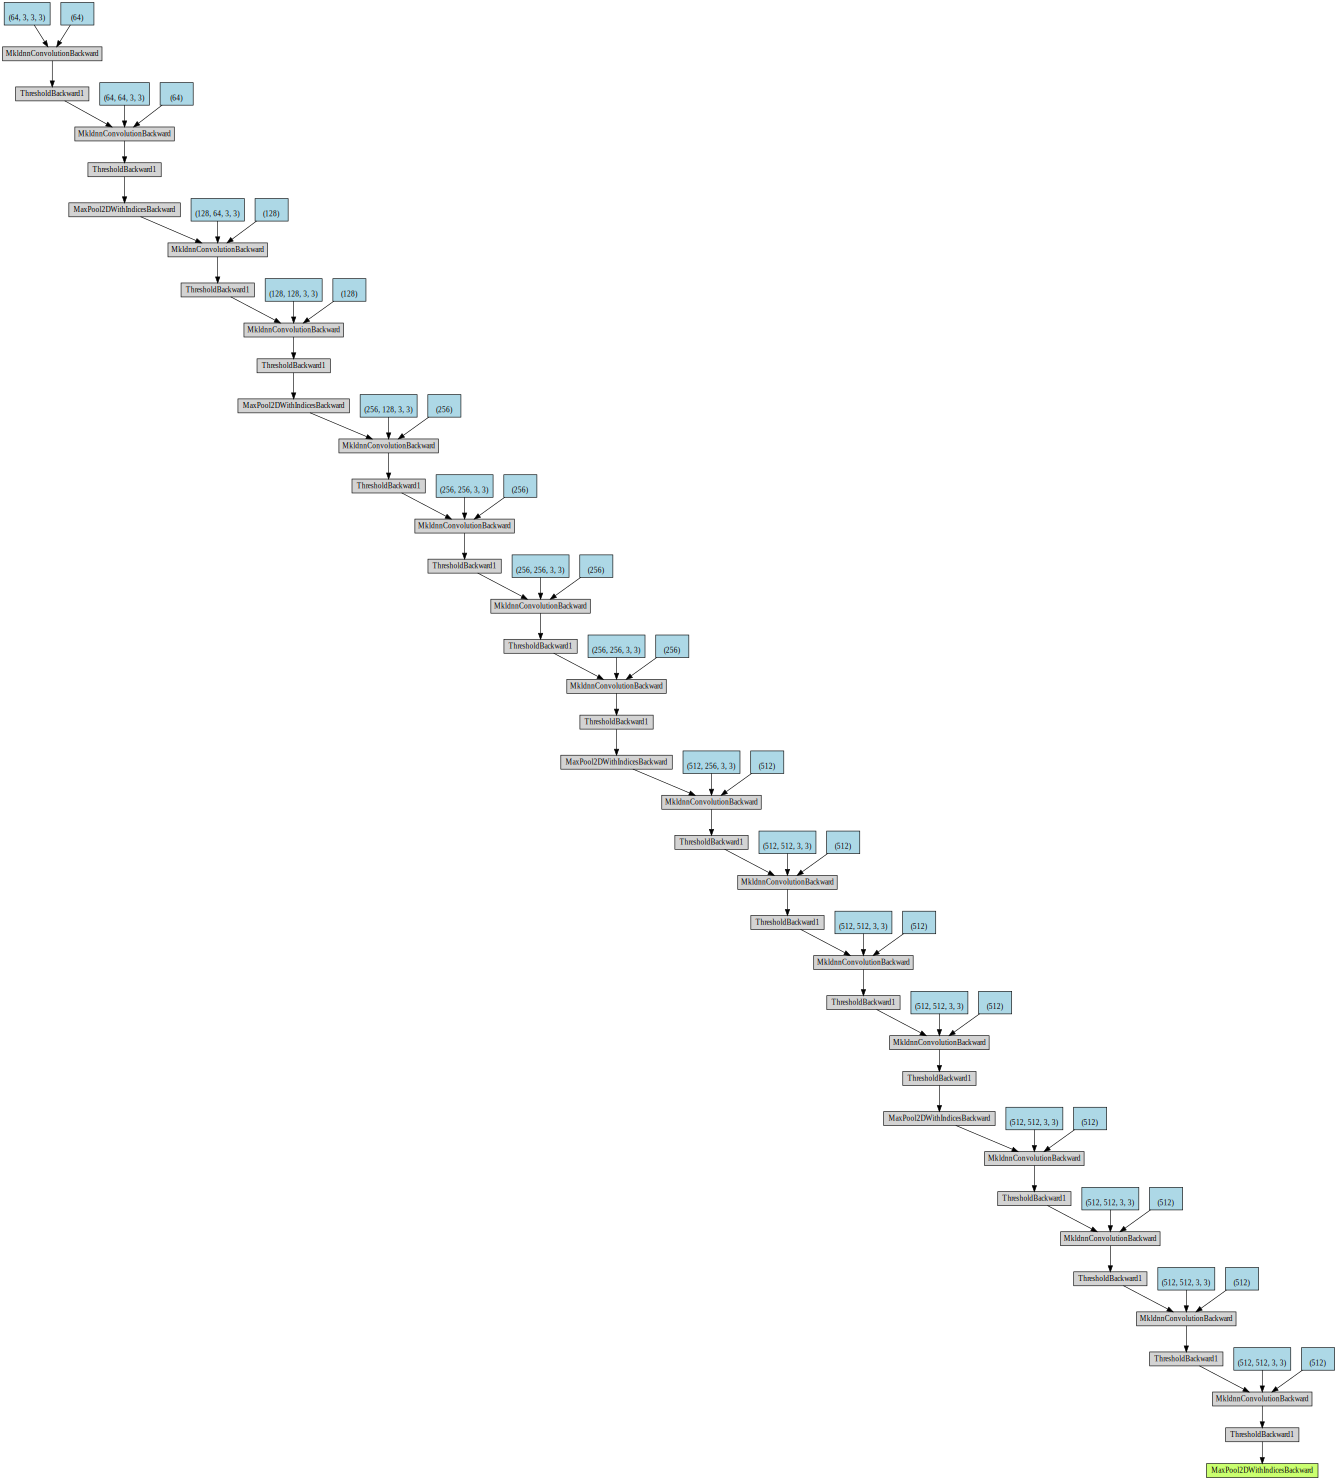

In [130]:
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = cnn(x)
make_dot(out)

## Modify the pre-trained model for style transfer

### Add normalization for input images
This is specific normalization required for VGG networks. Each channel for input images should be normalized by each channel normalized by `mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225]`

In [50]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

### Example of normalization
We use the functions `image_loader` and `imshow`, which is named here as `imshow_tensor` for tensor covered by [Style Transfer using Pytorch (Part 1)](https://h1ros.github.io/posts/style-transfer-using-pytorch-part-1/) to get the image as tensor.

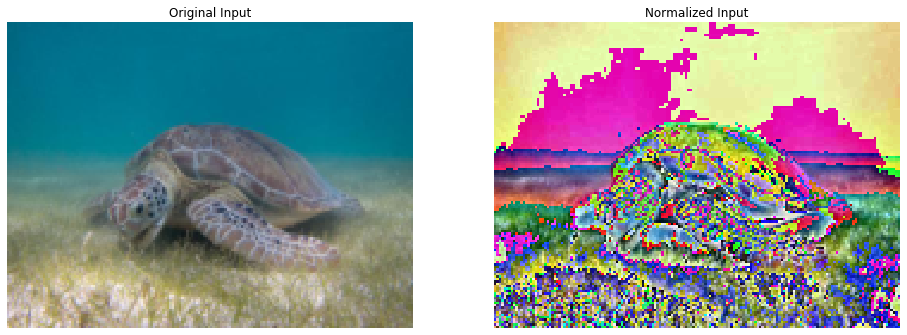

In [65]:
import warnings
warnings.filterwarnings("ignore")

# load an example image
img_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
img = image_loader(img_path)

# Normalize
normalize = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
img_norm = normalize.forward(img)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
imshow_tensor(img, ax=axes[0]);
axes[0].set_title('Original Input'); axes[0].axis('off');
imshow_tensor(img_norm, ax=axes[1]);
axes[1].set_title('Normalized Input'); axes[1].axis('off');



## Create a sequencial model for style transfer

In [131]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for n_child, layer in enumerate(cnn.children()):
        print()
        print(f"n_child: {n_child}")
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
        print(f'Name: {name}')
        if name in content_layers:
            print(f'Add content loss {i}')
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            print(f'Add style loss {i}')
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [123]:
style_img = image_loader(d_path['content'])
content_img = image_loader(d_path['style'])
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [132]:
# Obtain the model for style transfer
model, style_losses, content_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)


n_child: 0
Name: conv_1
Add style loss 1

n_child: 1
Name: relu_1

n_child: 2
Name: conv_2
Add style loss 2

n_child: 3
Name: relu_2

n_child: 4
Name: pool_2

n_child: 5
Name: conv_3
Add style loss 3

n_child: 6
Name: relu_3

n_child: 7
Name: conv_4
Add content loss 4
Add style loss 4

n_child: 8
Name: relu_4

n_child: 9
Name: pool_4

n_child: 10
Name: conv_5
Add style loss 5

n_child: 11
Name: relu_5

n_child: 12
Name: conv_6

n_child: 13
Name: relu_6

n_child: 14
Name: conv_7

n_child: 15
Name: relu_7

n_child: 16
Name: conv_8

n_child: 17
Name: relu_8

n_child: 18
Name: pool_8

n_child: 19
Name: conv_9

n_child: 20
Name: relu_9

n_child: 21
Name: conv_10

n_child: 22
Name: relu_10

n_child: 23
Name: conv_11

n_child: 24
Name: relu_11

n_child: 25
Name: conv_12

n_child: 26
Name: relu_12

n_child: 27
Name: pool_12

n_child: 28
Name: conv_13

n_child: 29
Name: relu_13

n_child: 30
Name: conv_14

n_child: 31
Name: relu_14

n_child: 32
Name: conv_15

n_child: 33
Name: relu_15

n_child:

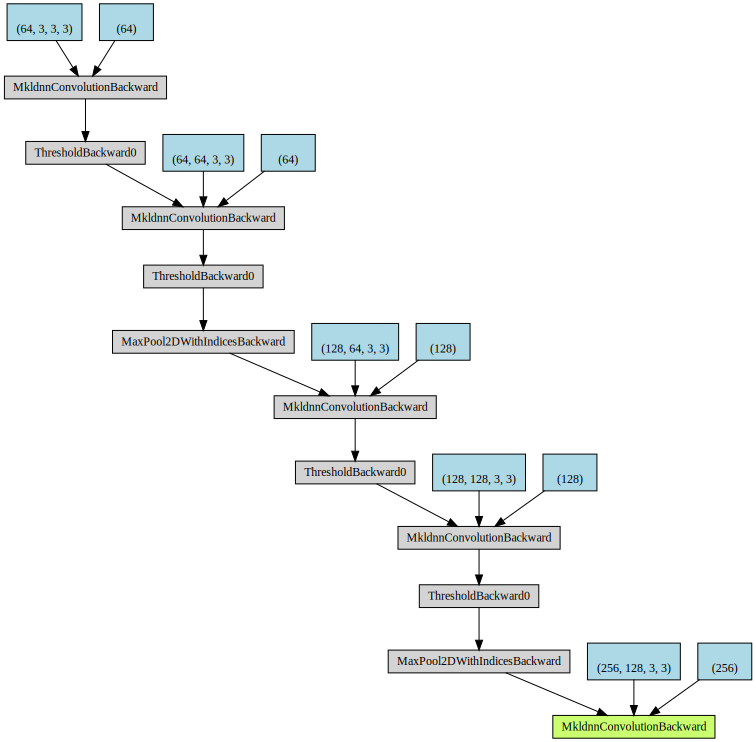

In [134]:
x = torch.zeros(1, 3, 128, 128, dtype=torch.float, requires_grad=False)
make_dot(model(x))